In [ ]:
!nvidia-smi

In [34]:
import os,sys
sys.path.append('/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/src')
import utils,build_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as python_random
from keras import backend as K
import create_dataset
from keras.utils import multi_gpu_model
from keras.optimizers import Adam
from nilearn.image import resample_img,concat_imgs,load_img,resample_to_img
from scipy.stats import zscore

In [2]:
data_path = '/home/ubuntu/hacking/data/stephan-data-ni-files'
input_shape = (91,109,91,1)
result_path = '/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/results/'
source_img_name = None
batch_size = 64
ngpus = 2
epochs = 1000
patience = 50
num_runs = 1
num_iters = 10
decayRate = 0.01
lr = 0.001
algo = 'shallow'
if os.path.isdir(result_path):
    print("result directory exists...")
else:
    print("Creating the result directory")
    os.mkdir(result_path)

result directory exists...


In [3]:
######################################################################################################################

dataset = create_dataset.generate_dataset(data_path,test_data_size=0.30)
train_rate,train_temp,train_imgs_list,flat_train_rate,flat_train_rate_zs = utils.get_rate_temp_img(dataset,subjs='train_subjs')
# val_rate,val_temp,val_imgs_list,flat_val_rate,flat_val_rate_zs = utils.get_rate_temp_img(dataset,subjs='val_subjs')
test_rate,test_temp,test_imgs_list,flat_test_rate,flat_test_rate_zs = utils.get_rate_temp_img(dataset,subjs='test_subjs')

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['X'] = train_temp
df_train['Y'] = flat_train_rate_zs

# df_val['X'] = val_temp
# df_val['Y'] = flat_val_rate_zs

df_test['X'] = test_temp
df_test['Y'] = flat_test_rate_zs



These are the studies to use ['NSF', 'BMRK3', 'BMRK4', 'IE', 'ILCP', 'EXP', 'SCEBL']
This is the test study BMRK5 


In [45]:
NSF = dataset['train_subjs'][0:26]
BMRK3 = dataset['train_subjs'][26:59]
BMRK4 = dataset['train_subjs'][59:87]
IE = dataset['train_subjs'][87:137]
ILCP = dataset['train_subjs'][137:166]
EXP = dataset['train_subjs'][166:183]
SCEBL = dataset['train_subjs'][183:]
BMRK5 = dataset['test_subjs']

In [54]:
# Extract raw and zscore ratings 
nsf_rating, nsf_rating_zs = utils.get_studywise_rating(dataset,NSF,compute_zscore=True)
bmrk3_rating, bmrk3_rating_zs = utils.get_studywise_rating(dataset,BMRK3,compute_zscore=True)
bmrk4_rating, bmrk4_rating_zs = utils.get_studywise_rating(dataset,BMRK4,compute_zscore=True)
ie_rating, ie_rating_zs = utils.get_studywise_rating(dataset,IE,compute_zscore=True)
ilcp_rating, ilcp_rating_zs = utils.get_studywise_rating(dataset,ILCP,compute_zscore=True)
exp_rating, exp_rating_zs = utils.get_studywise_rating(dataset,EXP,compute_zscore=True)
scebl_rating, scebl_rating_zs = utils.get_studywise_rating(dataset,SCEBL,compute_zscore=True)
bmrk5_rating, bmrk5_rating_zs = utils.get_studywise_rating(dataset,BMRK5,compute_zscore=True)
# Extract raw and z score temperature 
nsf_temp,nsf_temp_zs = utils.get_studywise_temp(dataset,NSF,compute_zscore=True)
bmrk3_temp,bmrk3_temp_zs = utils.get_studywise_temp(dataset,BMRK3,compute_zscore=True)
bmrk4_temp,bmrk4_temp_zs = utils.get_studywise_temp(dataset,BMRK4,compute_zscore=True)
ie_temp,ie_temp_zs = utils.get_studywise_temp(dataset,IE,compute_zscore=True)
ilcp_temp,ilcp_temp_zs = utils.get_studywise_temp(dataset,ILCP,compute_zscore=True)
exp_temp,exp_temp_zs = utils.get_studywise_temp(dataset,EXP,compute_zscore=True)
scebl_temp,scebl_temp_zs = utils.get_studywise_temp(dataset,SCEBL,compute_zscore=True)
bmrk5_temp,bmrk5_temp_zs = utils.get_studywise_temp(dataset,BMRK5,compute_zscore=True)

### Make some plots

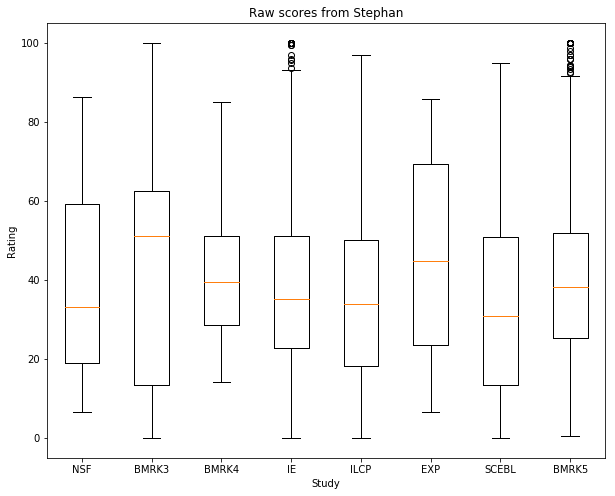

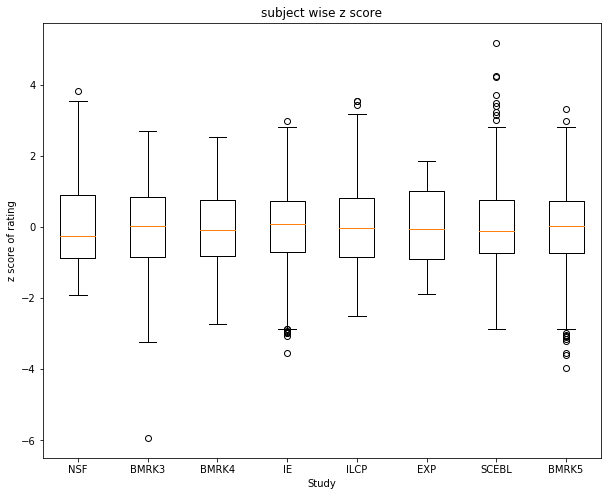

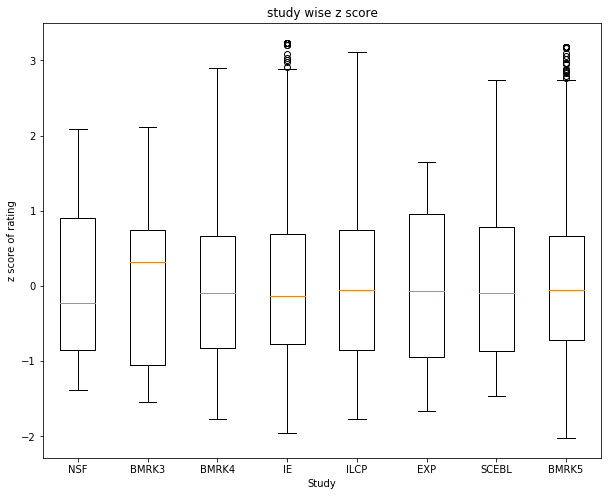

In [65]:
plt.figure(figsize=(10,8))
plt.boxplot([nsf_rating,bmrk3_rating,bmrk4_rating,ie_rating,ilcp_rating,exp_rating,scebl_rating,bmrk5_rating])
plt.xticks([1,2,3,4,5,6,7,8],['NSF','BMRK3','BMRK4','IE','ILCP','EXP','SCEBL','BMRK5'])
plt.title('Raw scores from Stephan')
plt.xlabel('Study')
plt.ylabel('Rating')
plt.savefig('study_wise_rating.png')
plt.show()

plt.figure(figsize=(10,8))
plt.boxplot([nsf_rating_zs,bmrk3_rating_zs,bmrk4_rating_zs,ie_rating_zs,ilcp_rating_zs,exp_rating_zs,
             scebl_rating_zs,bmrk5_rating_zs])
plt.xticks([1,2,3,4,5,6,7,8],['NSF','BMRK3','BMRK4','IE','ILCP','EXP','SCEBL','BMRK5'])
plt.title('subject wise z score')
plt.xlabel('Study')
plt.ylabel('z score of rating')
plt.savefig('subject_wise_zscore_rating.png')
plt.show()

plt.figure(figsize=(10,8))
plt.boxplot([zscore(nsf_rating),zscore(bmrk3_rating),zscore(bmrk4_rating),zscore(ie_rating),
             zscore(ilcp_rating),zscore(exp_rating),
             zscore(scebl_rating),zscore(bmrk5_rating)])
plt.xticks([1,2,3,4,5,6,7,8],['NSF','BMRK3','BMRK4','IE','ILCP','EXP','SCEBL','BMRK5'])
plt.title('study wise z score')
plt.xlabel('Study')
plt.ylabel('z score of rating')
plt.savefig('study_wise_zscore_rating.png')
plt.show()

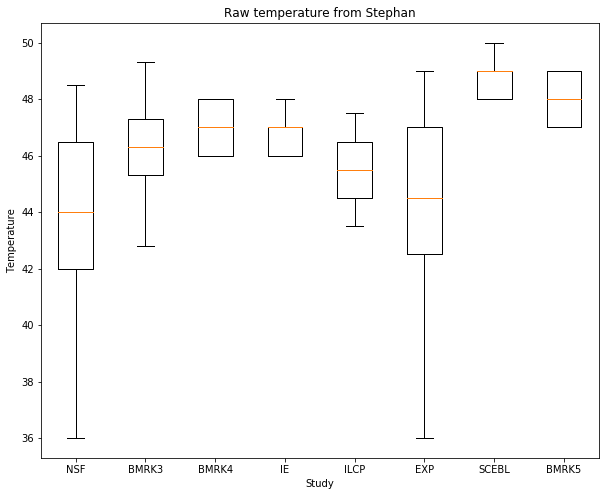

In [57]:
plt.figure(figsize=(10,8))
plt.boxplot([nsf_temp,bmrk3_temp,bmrk4_temp,ie_temp,ilcp_temp,exp_temp,scebl_temp,bmrk5_temp])
plt.xticks([1,2,3,4,5,6,7,8],['NSF','BMRK3','BMRK4','IE','ILCP','EXP','SCEBL','BMRK5'])
plt.title('Raw temperature from Stephan')
plt.xlabel('Study')
plt.ylabel('Temperature')
plt.savefig('study_wise_temperature.png')
plt.show()

# plt.figure(figsize=(10,8))
# plt.boxplot([nsf_temp_zs,bmrk3_temp_zs,bmrk4_temp_zs,ie_temp_zs,ilcp_temp_zs,exp_temp_zs,scebl_temp_zs,
#              bmrk5_temp_zs])
# plt.xticks([1,2,3,4,5,6,7,8],['NSF','BMRK3','BMRK4','IE','ILCP','EXP','SCEBL','BMRK5'])
# plt.title('z score')
# plt.xlabel('Study')
# plt.ylabel('Temperature')
# plt.savefig('subject_wise_zscore_temperature.png')
# plt.show()

In [60]:
#####################################################################################################################
# train_imgs_list[0:5],val_imgs_list[0:5],test_imgs_list[0:5]
#####################################################################################################################
train_imgs_list[0:5],test_imgs_list[0:5]

(['/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj1_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj2_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj3_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj4_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj5_zs.nii'],
 ['/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S850_OC1300_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S853_OC1307_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S860_OC1339_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S865_OC1328_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S872_OC1337_zs.nii'])

In [ ]:
print("Reading training images...")
train_imgs = utils.concat_imgs(train_imgs_list)
train_imgs = np.rollaxis(train_imgs.get_fdata(), 3, 0)[...,None]

# print("Reading validation images...")
# val_imgs = concat_imgs(val_imgs_list)
# val_imgs = np.rollaxis(val_imgs.get_fdata(), 3, 0)[...,None]
val_imgs  = None

print("Reading testing images...")
test_imgs = utils.concat_imgs(test_imgs_list)
test_imgs = np.rollaxis(test_imgs.get_fdata(), 3, 0)[...,None]

# print(train_imgs.shape,val_imgs.shape,test_imgs.shape)
input_shape = train_imgs.shape[1:]

pre_model = None #'/home/ubuntu/hacking/projects/deep-mediation/jan-2021/results-feb/model-iter-5.h5'


In [ ]:
train_params_df = utils.create_empty_df(num_runs,num_iters)
test_params_df = utils.create_empty_df(num_runs,num_iters)
start = 0
for runs in range(start,num_runs):
    K.clear_session()
    print("######################## Loading the model #####################")
    if pre_model == None:
        if algo == 'shallow':
            model = build_model.create_shallow_model3D(input_shape)
        else:
            model = build_model.create_deep_model3D(input_shape)
    else:
        print("Loading model %s"%pre_model)
        model = load_model(pre_model)
        model = model.layers[-2] #specifically for tf1.12. The model is saved with lambda layers. 
        
    if ngpus > 1:
        parallel_model = multi_gpu_model(model,gpus=ngpus)
    else:
        parallel_model = model
        
    opt = Adam(lr, beta_1=0.9, beta_2=0.999,decay=decayRate)
    parallel_model.compile(loss='mean_absolute_error',optimizer=opt)    
    suffix= ''
    print("################################ Start mediation analysis ##################################")
    train_params_df,test_params_df,z_train = utils.simulate_mediation(df_train,df_test,train_imgs,test_imgs,
                    train_params_df,test_params_df,parallel_model,suffix,n_runs=runs,batchSize=batch_size,nEpochs=epochs,
                    iterations=num_iters,pat=patience,output_path=result_path,use_model=None,algo=algo)
train_params_df.to_excel(os.path.join(result_path,'train-'+algo+'.xlsx'))
test_params_df.to_excel(os.path.join(result_path,'test-'+algo+'.xlsx'))

### Concatenate test images path

In [ ]:
def get_image_name(test_imgs_list):
    from pathlib import Path
    test_img_names = []
    for i in test_imgs_list:
        test_img_names.append([Path(i).name]*(load_img(i).shape[-1]))
    test_img_names = np.concatenate(test_img_names)
    return test_img_names

In [ ]:
test_img_names = get_image_name(test_imgs_list)

In [ ]:
# from pathlib import Path
# test_img_names = []
# for i in test_imgs_list:
#     test_img_names.append([Path(i).name]*(load_img(i).shape[-1]))
# test_img_names = np.concatenate(test_img_names)

### Create an empty dataframe

In [ ]:
# df_test_params=pd.DataFrame(columns = ['alpha0','beta0','alpha','beta','gamma'])
# df_test_params.loc[0,'alpha0']=0
# df_test_params.loc[0,'beta0']=0
# df_test_params.loc[0,'alpha']=0
# df_test_params.loc[0,'beta']=0
# df_test_params.loc[0,'gamma']=0

In [ ]:
from keras.models import load_model
n_runs = 0

for i in range(0,num_iters):
    model_path = os.path.join(result_path,algo+'-iter-'+str(i+1)+'-run-'+str(n_runs)+suffix+'.h5')
    print(model_path)
    model_to_use = load_model(model_path)
    alph0_test,alph_test,beta0_test,bet_test,gam_test,z_test = utils.predict_mediation(model_to_use,test_imgs,
                                                                                       df_test)
    df_test['Z'] = z_test
    df_test['image-name'] = test_img_names
    df_test.to_excel(os.path.join(result_path,'df_test_using_model_'+str(i+1)+'.xlsx'))
    
    df_test_params=pd.DataFrame(columns = ['alpha0','beta0','alpha','beta','gamma'])
    df_test_params.loc[0,'alpha0']=alph0_test
    df_test_params.loc[0,'beta0']=beta0_test
    df_test_params.loc[0,'alpha']=alph_test
    df_test_params.loc[0,'beta']=bet_test
    df_test_params.loc[0,'gamma']=gam_test
    df_test_params.to_excel(os.path.join(result_path,'df_test_params_model_'+str(i+1)+'.xlsx'))

In [ ]:
data_path = '/home/ubuntu/hacking/data/stephan-data-ni-files/sound_data'
sound_temp_files,sound_ratings_files,sound_images_files = utils.get_sound_files(data_path)

In [ ]:
temp_mat_file = utils.read_sound_files(sound_temp_files,kind='temp')
rating_mat_file = utils.read_sound_files(sound_ratings_files,kind='rate')
sound_images = utils.read_sound_files(sound_images_files,kind='nii')
sound_images = np.rollaxis(sound_images.get_fdata(), 3, 0)[...,None]

In [ ]:
sound_images_names = get_image_name(sound_images_files)

In [ ]:
df_sound = pd.DataFrame()
df_sound['X'] = temp_mat_file
df_sound['Y'] = rating_mat_file

In [ ]:
from keras.models import load_model
n_runs = 0

for i in range(0,num_iters):
    model_path = os.path.join(result_path,algo+'-iter-'+str(i+1)+'-run-'+str(n_runs)+suffix+'.h5')
    print(model_path)
    model_to_use = load_model(model_path)
    alph0_test,alph_test,beta0_test,bet_test,gam_test,z_test = utils.predict_mediation(model_to_use,sound_images,
                                                                                       df_sound)
    df_sound['Z'] = z_test
    df_sound['image-name'] = sound_images_names
    df_sound.to_excel(os.path.join(result_path,'df_sound_using_model_'+str(i+1)+'.xlsx'))
    
    df_sound_params=pd.DataFrame(columns = ['alpha0','beta0','alpha','beta','gamma'])
    df_sound_params.loc[0,'alpha0']=alph0_test
    df_sound_params.loc[0,'beta0']=beta0_test
    df_sound_params.loc[0,'alpha']=alph_test
    df_sound_params.loc[0,'beta']=bet_test
    df_sound_params.loc[0,'gamma']=gam_test
    df_sound_params.to_excel(os.path.join(result_path,'df_sound_params_model_'+str(i+1)+'.xlsx'))

### Choose the best model

In [ ]:
# model_path = '/home/ubuntu/hacking/projects/deep-mediation/dec-2020/results/attempt-0/model-iter-3.h5'
# model_to_use = load_model(model_path)

In [ ]:
# alph0_test,alph_test,beta0_test,bet_test,gam_test,z_test = utils.predict_mediation(model_to_use,test_imgs,df_test)

In [ ]:
# df_test['Z'] = z_test
# df_test['image-name'] = test_img_names
# df_test.to_excel(os.path.join(result_path,'df_test_using_model_3_jan-14.xlsx'))

# df_test_params=pd.DataFrame()
# df_test_params['alpha0'] = alph0_test
# df_test_params['beta0'] = beta0_test
# df_test_params['alpha'] = alph_test
# df_test_params['beta'] = bet_test
# df_test_params['gamma'] = gam_test
# df_test_params.to_excel(os.path.join(result_path,'params_df_test_model_3_jan-14.xlsx'))

In [ ]:
train_params_df = utils.create_empty_df(num_runs,num_iters)
test_params_df = utils.create_empty_df(num_runs,num_iters)

# create a model 
algo = 'shallow'
print("######################## Loading the model #####################")
if pre_model == None:
    if algo == 'shallow':
        model = build_model.create_shallow_model3D(input_shape)
    else:
        model = build_model.create_deep_model3D(input_shape)
else:
    print("Loading model %s"%pre_model)
    model = load_model(pre_model)
    model = model.layers[-2] #specifically for tf1.12. The model is saved with lambda layers. 

if ngpus > 1:
    parallel_model = multi_gpu_model(model,gpus=ngpus)
else:
    parallel_model = model
    
opt = Adam(lr, beta_1=0.9, beta_2=0.999,decay=decayRate)
parallel_model.compile(loss='mean_absolute_error',optimizer=opt)
print("################################ Start mediation analysis ##################################")
parallel_model.summary()
suffix = ""
train_params_df,test_params_df,z_train = utils.simulate_mediation(df_train,df_test,train_imgs,test_imgs,
                    train_params_df,test_params_df,parallel_model,suffix,n_runs=0,batchSize=batch_size,nEpochs=epochs,
                    iterations=num_iters,pat=patience,output_path=result_path,use_model=None,algo=algo)

train_params_df.to_excel(os.path.join(result_path,'train-'+algo+'.xlsx'))
test_params_df.to_excel(os.path.join(result_path,'test-'+algo+'.xlsx'))

### For tensorflow > 2.2

In [ ]:
train_params_df = utils.create_empty_df(num_runs,num_iters)
test_params_df = utils.create_empty_df(num_runs,num_iters)
start = 0
for runs in range(start,num_runs):
    K.clear_session()
    print("######################## Loading the model #####################")
    strategy = tf.distribute.MirroredStrategy()
    print('###################### Number of devices: {}######################'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        print("################Creating the model###################")
        if pre_model == None:
            if algo == 'shallow':
                model = build_model.create_shallow_model3D(input_shape)
            else:
                model = build_model.create_deep_model3D(input_shape)
        else:
            print("Loading model %s"%pre_model)
            model = load_model(pre_model)
            model = model.layers[-2] #specifically for tf1.12. The model is saved with lambda layers. 

        print("################################ Start mediation analysis ##################################")
        model.summary()
        suffix= ''
        print("################################ Start mediation analysis ##################################")
        train_params_df,test_params_df,z_train = utils.simulate_mediation(df_train,df_test,train_imgs,test_imgs,
                        train_params_df,test_params_df,parallel_model,suffix,n_runs=runs,batchSize=batch_size,nEpochs=epochs,
                        iterations=num_iters,pat=patience,output_path=result_path,use_model=None,algo=algo)

train_params_df.to_excel(os.path.join(result_path,'train-'+algo+'.xlsx'))
test_params_df.to_excel(os.path.join(result_path,'test-'+algo+'.xlsx'))

In [ ]:
#####################################################################################################################

print("######################## Loading the model #####################")
if pre_model == None:
    model = build_model.create_shallow_model3D(input_shape)
else:
    print("Loading model %s"%pre_model)
    model = load_model(pre_model)
    model = model.layers[-2] #specifically for tf1.12. The model is saved with lambda layers. 

model.summary()
if ngpus > 1:
    parallel_model = multi_gpu_model(model,gpus=ngpus)
else:
    parallel_model = model
    print("################Creating the model###################")
    
opt = Adam(lr, beta_1=0.9, beta_2=0.999,decay=decayRate)
parallel_model.compile(loss='mean_absolute_error',optimizer=opt)

print("################################ Start mediation analysis ##################################")
output_df = utils.create_empty_df(num_runs,iterations)
for runs in range(num_runs):
    params_df,z_final_train,z_final_val,parallel_model_final = utils.simulate_mediation(df_train,
                                df_val,df_test,train_imgs,val_imgs,test_imgs,output_df,
                                parallel_model,runs,batchSize,nEpochs,iterations,pat,
                                output_path=result_path,use_model=pre_model)